<a href="https://colab.research.google.com/github/kevinMGII/Grupo7-Practica1/blob/main/Grupo7_Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRIMERA PRÁCTICA**. Predicción del Abandono de Empleados.

Grupo 7. Miembros:

*   *Kevin Medina García, 100495893.*
*   *Bárbara Sánchez Moratalla, 100495857.*






---



### **1. CARGA Y VISUALIZACIÓN DE LOS DATOS**

A lo largo de este notebook se utilizarán los archivos que contienen los datos con la extensión 12. Cumpliendo así las consideraciones generales, puesto que la suma de los últimos dos dígitos de nuestros NIA's es 12 en ambos casos.

 A continuación, leemos el conjunto de datos y mostramos las primeras filas.

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)                                      # Esta opción nos permite mostrar todas las columnas del conjunto de datos
data_train = pd.read_csv("./attrition_availabledata_12.csv.gz")                 # Cargamos el conjunto de datos de entrenamiento utilizando el almacenamiento local de Google Colab.
data_train.head()                                                               # Mostramos las 5 primeras filas del conjunto de datos de entrenamiento.

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.919459,7,4,3,4.0,2.0,3.0,35,Travel_Rarely,Research & Development,1,3,Life Sciences,1,1860,Male,3,Healthcare Representative,Married,167920,3.0,Y,12,8,1,16.0,3,13,4,8,No
1,6.616015,11,3,3,1.0,3.0,2.0,38,Travel_Rarely,Research & Development,1,2,Medical,1,4376,Male,4,Laboratory Technician,Divorced,64720,0.0,Y,12,8,0,17.0,4,16,5,13,No
2,7.522345,15,2,3,1.0,3.0,3.0,45,Travel_Frequently,Sales,21,1,Marketing,1,2932,Male,3,Research Scientist,Married,22890,4.0,Y,13,8,0,9.0,3,3,0,2,No
3,6.677000,18,1,3,3.0,3.0,3.0,21,Travel_Rarely,Sales,16,2,Life Sciences,1,1709,Male,3,Sales Executive,Single,87260,1.0,Y,11,8,1,3.0,2,3,1,2,No
4,5.685287,23,3,4,3.0,4.0,2.0,30,Non-Travel,Sales,10,2,Life Sciences,1,1639,Male,3,Laboratory Technician,Single,188800,0.0,Y,22,8,1,12.0,3,11,6,7,No


 ---

### **2. EDA SIMPLIFICADO**

A continuación, realizamos un Análisis Exploratorio de Datos (EDA). El objetivo es obtener una visión general del estado de los datos, permitiéndonos llevar a cabo algunos ajustes o limpiezas posteriormente en el preproceso de los datos.



**Número de  variables e instancias:**

In [2]:
num_instancias, num_variables = data_train.shape                                # Usamos el atributo .shape de pandas para obtener la tupla (número de filas, número de columnas)
print("Número de instancias:", num_instancias)                                  # Mostramos por pantalla num_instancias (número de filas)
print("Número de variables:", num_variables)                                    # Mostramos por pantalla num_variables (número de columnas)

Número de instancias: 2940
Número de variables: 31


El conjunto de datos de entrenamiento que vamos a utilizar en este notebook está compuesto por 2940 instancias y 31 variables. Disponemos de una cantidad suficiente de datos como para entrenar un modelo de forma correcta.

**Tipos de variables (categóricas, numéricas u ordinales):**

In [5]:
tipos = data_train.dtypes                                                       # Almacenamos los tipos de datos de cada columna del conjunto de datos de entrenamiento.
                                                                                # Seleccionamos los tipos de datos categóricos y numéricos con pandas
categoricas = data_train.select_dtypes(include=['object', 'category']).columns  # Variables categóricas: aquellas de tipo 'object' o 'category'
numericas = data_train.select_dtypes(include=['int64', 'float64']).columns      # Variables numéricas: aquellas de tipo 'int64' o 'float64'
# Las variables ordinales deben identificarse manualmente (mirar Nota)

tipo_variable = []                                                              # Creamos una lista para almacenar el tipo de cada columna
for columna in tipos.index:                                                     # Recorremos todas las columnas del Dataframe
    if columna in categoricas:                                                  # Check: ¿La columna es categórica?
        tipo_variable.append('Categórica')                                      # Si es categórica, la añadimos a la lista tipo_variable
    else:                                                                       # En otro caso
        tipo_variable.append('Numérica')                                        # Añadimos la variable numérica a la lista tipo_variable

tipos_dataframe = pd.DataFrame({                                                # Creamos un dataframe con la información (Consideraciones Generales)
    'Columna': tipos.index,                                                     # Nombre de la columna
    'Tipo de Dato': tipos.values,                                               # Tipo de dato (int64, object, ...)
    'Tipo de Variable': tipo_variable                                           # Tipo de la variable (categórica, numérica)
})

tipos_dataframe                                                                 # Mostramos el dataframe

,Columna,Tipo de Dato,Tipo de Variable
0,hrs,float64,Numérica
1,absences,int64,Numérica
2,JobInvolvement,int64,Numérica
3,PerformanceRating,int64,Numérica
4,EnvironmentSatisfaction,float64,Numérica
5,JobSatisfaction,float64,Numérica
6,WorkLifeBalance,float64,Numérica
7,Age,int64,Numérica
8,BusinessTravel,object,Categórica
9,Department,object,Categórica


Encontramos mayoritariamente variables numéricas en el conjunto de datos: 23 variables numéricas, 8 variables categóricas.

*Nota: pandas no es capaz de identificar variables ordinales automáticamente.*


*Debemos analizar cada variable categórica y estudiar si existe un orden jerárquico entre los valores.*


```
# Para ver valores únicos de la columna 'X' en el conjunto de entrenamiento (se ha hecho de forma auxiliar)
print(data_train['X'].unique())
```

| Variable        | Valores Ejemplo                                           | ¿Tiene Orden? |
|----------------|-----------------------------------------------------------|----------------|
| **BusinessTravel** | Non-Travel, Travel_Rarely, Travel_Frequently              |  Sí           |
| **Department**     | Research & Development, Sales, Human Resources            |  No           |
| **EducationField** | Marketing, Medical, Life Sciences                         |  No           |
| **Gender**         | Male, Female                                              |  Sí           |
| **JobRole**        | Research Director, Sales Executive, Lab Technician        |  No           |
| **MaritalStatus**  | Single, Married, Divorced                                 |  Sí           |
| **Over18**         | N, Y                                                      |  Sí           |


*Concluimos que hay 4 variables ordinales: BusinessTravel, Gender, MaritalStatus y Over18.*

**Variables categóricas con alta cardinalidad:**

In [10]:
cardinalidades = []
for col in data_train.columns:                                                  # Recorremos las columnas del conjunto de datos: data_train
    tipo_columna = data_train[col].dtype                                        # Almacenamos en una variable el tipo de dato de la columna actual
    if tipo_columna == 'object' or tipo_columna.name == 'category':             # Check: ¿El tipo es un objeto, texto?, ¿El tipo es una categoría?
        valores_unicos = data_train[col].unique()                               # Almacenamos en una variable los valores únicos de esa categoría
        num_valores_unicos = len(valores_unicos)                                # Obtenemos la cantidad de valores únicos que hay
        cardinalidades.append((col, num_valores_unicos))                        # Guardamos nombre y cardinalidad

dataframe_cardinalidad = pd.DataFrame(cardinalidades, columns=['Columna', 'Cardinalidad'])   # Creamos un dataframe con la información (Consideraciones Generales)
dataframe_cardinalidad.sort_values(by='Cardinalidad', ascending=False, inplace=True)         # Ordenamos el dataframe por cardinalidad de forma descendente
dataframe_cardinalidad                                                                       # Mostramos el dataframe

,Columna,Cardinalidad
4,JobRole,9
2,EducationField,6
1,Department,3
0,BusinessTravel,3
5,MaritalStatus,3
3,Gender,2
7,Attrition,2
6,Over18,1


El resultado obtenido nos indica que la mayoría de variables categóricas en el conjunto de datos de entrenamiento presentan una baja cardinalidad, aunque algunas de ellas como "JobRole" tienen una alta cardinalidad con hasta 9 valores distintos. Además, vemos como "Over18" solamente tiene un valor, por lo que no aporta información relevante y debe ser eliminada.

**Variables con valores faltantes y cuántos son:**

In [9]:
faltantes = []
for col in data_train.columns:                                                  # Recorremos las columnas del conjunto de datos: data_train
    contador_faltantes = 0                                                      # Inicializamos el contador de faltantes a 0
    for valor in data_train[col]:                                               # Recorremos los valores de la columna
        if valor is None or valor != valor:                                     # Check: ¿El valor es nulo (faltante)? Especial: valor != valor para detectar NaN
            contador_faltantes += 1                                             # Incrementamos el contador de faltantes en una unidad
    if contador_faltantes > 0:                                                  # Check: ¿Hay valores faltantes en esa columna?
        faltantes.append((col, contador_faltantes))                             # Guardamos nombre y faltantes

dataframe_faltantes = pd.DataFrame(faltantes, columns=['Columna', 'Valores Faltantes'])    # Creamos un dataframe con la información (Consideraciones Generales)
dataframe_faltantes.sort_values(by='Valores Faltantes', ascending=False, inplace=True)     # Ordenamos el dataframe por cardinalidad de forma descendente
dataframe_faltantes                                                                        # Mostramos el dataframe

,Columna,Valores Faltantes
2,WorkLifeBalance,23
0,EnvironmentSatisfaction,17
3,NumCompaniesWorked,12
1,JobSatisfaction,8
4,TotalWorkingYears,7


Tras la ejecución, se puede observar como tenemos cinco variables con valores faltantes, destacando alguna como "WorkLifeBalance" con hasta 23 valores no presentes, o "EnvironmentSatisfaction" con hasta 17. Durante el desarrollo del notebook determinaremos qué estrategia seguir para solventar este problema, analizando el impacto de estas variables.

**Columnas constantes o columnas de ID:**

In [12]:
columnas_info = []                                                              # Lista para guardar los resultados
for col in data_train.columns:                                                  # Recorremos las columnas del conjunto de datos: data_train
    valores_unicos = data_train[col].unique()                                   # Obtenemos los valores únicos de la columna
    if len(valores_unicos) == 1 and valores_unicos[0] == valores_unicos[0]:     # Check: ¿La columna tiene un solo valor? Especial: ...[0] == ...[0] para detectar NaN
        columnas_info.append((col, 'Constante'))                                # Guardamos la variable con la columna constante
    elif len(valores_unicos) == len(data_train):                                # Check: ¿El número de valores únicos es igual al número de filas?
        columnas_info.append((col, 'Posible ID'))                               # Guardamos la posible variable o columna de ID

dataframe_columnas_info = pd.DataFrame(columnas_info, columns=['Columna', 'Tipo'])     # Creamos un dataframe con la información (Consideraciones Generales)
dataframe_columnas_info                                                                # Mostramos el dataframe

,Columna,Tipo
0,EmployeeCount,Constante
1,EmployeeID,Posible ID
2,Over18,Constante
3,StandardHours,Constante


Identificamos tres columnas constantes: "EmployeeCount", "Over18" y "StandardHours", así como una posible columna de id: "EmployeeID". Las columnas constantes no aportan información relevante o que resulte útil al modelo, y pueden eliminarse. La columna de ID contiene valores únicos para cada fila, por lo que no contribuye al modelo y puede eliminarse.

**Comprobación del tipo de problema: ¿clasificación o regresión?**

In [14]:
datos_col = data_train["Attrition"]                                             # Seleccionamos la columna "Attrition" del conjunto de datos de entrenamiento
valores_unicos = datos_col.unique()                                             # Obtenemos los valores únicos de la columna "Attrition"

dataframe_valores_unicos = pd.DataFrame(valores_unicos, columns=["Attrition"])  # Creamos un dataframe con la información (Consideraciones Generales)
dataframe_valores_unicos                                                        # Mostramos el dataframe

,Attrition
0,No
1,Yes


Como podemos observar en el resultado de la ejecución, se trata de un problema de clasificación binaria. El modelo será capaz de predecir una de las dos categorías: No, Yes.

**Puesto que es un problema de clasificación, ¿está desbalanceado?**

In [21]:
datos_col = data_train["Attrition"]                                             # Seleccionamos la columna "Attrition" del conjunto de datos de entrenamiento
contador_clases = datos_col.value_counts()                                      # Contamos la cantidad de valores de cada clase en la columna "Attrition"

dataframe_contador_clases = pd.DataFrame(contador_clases)                       # Creamos un DataFrame con la información
dataframe_contador_clases.columns = ["Frecuencia"]                              # Por defecto se pone count, renombramos solo para un mejor entendimiento
dataframe_contador_clases                                                       # Mostramos el DataFrame

,Frecuencia
Attrition,
No,2466
Yes,474


Concluimos el Análisis Exploratorio de Datos (EDA) indicando que el problema de clasificación está desbalanceado. Esto es debido a que existe una mayor cantidad de valores en una categoría: "No", respecto a la otra: "Yes".

Un conjunto de datos desbalanceado puede provocar que el modelo aprenda mejor la categoría con mayor cantidad de valores y no aprenda correctamente la categoría con menor cantidad de valores.



---



### **3. CÓMO SE VA A REALIZAR LA EVALUACIÓN**

Tras realizar el EDA simplicado y observar que se trata de un problema de clasificación binaria desbalanceado, definimos en esta sección la estrategia de evaluación con la que entrenar y evaluar el modelo.

Para comprender los resultados emplearemos diversas métricas:
* Accuracy: fracción de predicciones correctas (tanto positivas como negativas) sobre el total de predicciones.
* TPR (True Positive Rate): fracción de positivos reales correctamente identificados.
* TNR (True Negative Rate): fracción de negativos reales correctamente identificados.
* Balanced Accuracy: media del TPR y TNR, útil para datasets desbalanceados.
* Matriz de confusión: matriz que muestra la proporción de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

**3.1. Holdout: División en Train y Test**

Antes de separar los datos en entrenamiento y test, limpiamos el conjunto de datos quitando aquellas variables que resultan irrelevantes, como se ha observado en el segundo apartado *(EmployeeID, EmployeeCount, Over18, StandardHours)*.

También eliminamos la columna 'Attrition' de las features X, ya que 'Attrition' es la variable a predecir y de lo contrario se produciría data leakage (el modelo entrenara con los datos de evaluación).

Por otro lado, debemos transformar las variables categóricas para que adopten valores numéricos. Para los casos en los que no hay relación entre los valores, se aplicará one-hot enconding; mientras que para los casos en los que sí, se mapearán de forma ordenada.

Similarmente, debemos transformar la columna *Attrition* de los datos de test. Al tratarse de una variable binaria, transformamos sus valores categóricos ("No" y "Yes") en numéricos (0 y 1) respectivamente. Es decir, aplicamos label encoding.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd

categorical_features = ['Department', 'EducationField', 'JobRole']                       # Lista de atributos categóricos
ordinal_features = ['BusinessTravel', 'Gender', 'MaritalStatus']                         # Lista de atributos ordinales
drop_columns = ["EmployeeID", "EmployeeCount", "Over18", "StandardHours", "Attrition"]   # Lista con las columnas innecesarias. Análisis anteriores.

ordinal_mapping = [                                                             # Lista con los posibles valores de las variables ordinales
    ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],                       # Posibles valores de BusinnesTravel
    ['Male', 'Female'],                                                         # Posibles valores de Gender
    ['Married', 'Divorced', 'Single']                                           # Posibles valores de MaritalStatus
]

preprocessor = ColumnTransformer(                                               # Utilizamos ColumnTransformer para aplicar transformar columnas no numéricas a numéricas
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),             # Aplicamos OneHotEncoding a las variables categóricas
        ('ord', OrdinalEncoder(categories=ordinal_mapping), ordinal_features)   # Aplicamos OrdinalEncoding a las variables ordinales
    ],
    remainder='passthrough'                                                     # Mantenemos las columnas numéricas sin cambios
)

X = data_train.drop(columns=drop_columns)                                                       # Eliminamos las columnas innecesarias
X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())   # Utilizamos el preprocessor.fit para aplicarlo

y = data_train['Attrition'].map({'No': 0, 'Yes': 1})                            # Convertimos usando map la variable objetivo a numérica

Ahora sí, dividimos los datos en train (66.6%) y test (33.3%), ya que haremos la evaluación final del modelo con el método Holdout. Usamos como semilla el NIA de uno de los miembros del grupo, como se exige en el enunciado.


In [ ]:
NIA = 100495893                                                                  # A lo largo de la práctica, utilizaremos este NIA para reproducir resultados

Además, al tratarse de un problema desbalanceado, es importante estratificar los datos *(stratify=y)* a la hora de hacer la separación para tener para tener el mismo desbalance en el conjunto de entrenamiento y en el de prueba. De lo contrario, el conjunto de entrenamiento podría no reflejar la distribución real de 'Attrition' y resultar poco útil para entrenar el modelo.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=NIA)       # Dividimos en train y test
print("Número de instancias de train:", X_train.shape[0], "instancias")                                       # Imprimimos el número de instancias de entrenamiento
print("Número de instancias de test:", X_test.shape[0], "instancias")                                         # Imprimimos el número de instancias de test

Número de instancias de train: 1969 instancias
Número de instancias de test: 971 instancias


**3.2. Evaluación Inner: Optimización de Hiperparámetros y Comparación de Modelos**

La evaluación interna del modelo nos será útil para optimizar los hiperparámetros y elegir el mejor modelo.

Para realizarla aplicaremos validación cruzada en el conjunto de datos de entrenamiento y, puesto que se trata de un problema desbalanceado, dicha validación será estratificada también.

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv_inner = StratifiedKFold(                                                     # Inner evaluation -> validación cruzada estratificada (StratifiedKFold)
    n_splits=3,                                                                 # División del conjunto de entrenamiento en 5 particiones o folds.
    shuffle=True,                                                               # Se mezclan los datos antes de dividirlos para mayor aleatoriedad
    random_state=NIA                                                            # Se fija una semilla para garantizar reproducibilidad, en este caso, el NIA.
)                                                                               # cv_inner es un objeto que utilizamos en el siguiente apartado

---

### **4. MÉTODOS BÁSICOS: KNN Y TREES**

PREPROCESADO DE DATOS


- **Escalado e imputación usando KNN:**



En este apartado se lleva a cabo la evaluación de distintos métodos de escalado e imputación, los cuales se emplean para preprocesar los datos (escalado para mapear los valores a cierto rango e imputación para rellenar valores faltantes). Utilizaremos validación cruzada, con K-Nearest Neighbors (KNN) como referencia. De este modo obtendremos la mejor combinación para aplicarla en el modelo final.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

inner_scores = {}                                                               # Diccionario para almacenar los resultados de cada combinación

# Alternativa 1.1: KNN con StandardScaler ∧ Media
pipeline_std_mean = Pipeline([                                                  # Creacion del Pipeline: Imputer: mean | Scaler: standard | KNN
    ('imputer', SimpleImputer(strategy="mean")),                                # Imputación de valores faltantes con la media
    ('scaler', StandardScaler()),                                               # Escalado mediante StandardScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_std = cross_val_score(pipeline_std_mean, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")             # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con StandardScaler ∧ Media'] = scores_std.mean()                                                  # Se almacena el resultado en el diccionario inner_scores{}

# Alternativa 1.2: KNN con StandardScaler ∧ Mediana
pipeline_std_median = Pipeline([                                                # Creacion del Pipeline: Imputer: mean | Scaler: standard | KNN
    ('imputer', SimpleImputer(strategy="median")),                              # Imputación de valores faltantes con la media
    ('scaler', StandardScaler()),                                               # Escalado mediante StandardScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_std = cross_val_score(pipeline_std_median, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")          # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con StandardScaler ∧ Mediana'] = scores_std.mean()                                               # Se almacena el resultado en el diccionario inner_scores{}

# Alternativa 2.1: KNN con MinMaxScaler ∧ Media
pipeline_minmax_mean = Pipeline([                                                    # Creacion del Pipeline: Imputer: mean | Scaler: minmax | KNN
    ('imputer', SimpleImputer(strategy="mean")),                                # Imputación de valores faltantes con la media
    ('scaler', MinMaxScaler()),                                                 # Escalado mediante MinMaxScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_minmax = cross_val_score(pipeline_minmax_mean, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con MinMaxScaler ∧ Media'] = scores_minmax.mean()                                              # Se almacena el resultado en el diccionario inner_scores{}

# Alternativa 2.2: KNN con MinMaxScaler ∧ Mediana
pipeline_minmax_median = Pipeline([                                                    # Creacion del Pipeline: Imputer: mean | Scaler: minmax | KNN
    ('imputer', SimpleImputer(strategy="median")),                              # Imputación de valores faltantes con la media
    ('scaler', MinMaxScaler()),                                                 # Escalado mediante MinMaxScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_minmax = cross_val_score(pipeline_minmax_median, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con MinMaxScaler ∧ Mediana'] = scores_minmax.mean()                                              # Se almacena el resultado en el diccionario inner_scores{}

# Alternativa 3.1: KNN con RobustScaler ∧ Media
pipeline_robust_mean = Pipeline([                                               # Creacion del Pipeline: Imputer: mean | Scaler: robustscaler | KNN
    ('imputer', SimpleImputer(strategy="mean")),                                # Imputación de valores faltantes con la media
    ('scaler', RobustScaler()),                                                 # Escalado mediante RobustScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_robust = cross_val_score(pipeline_robust_mean, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con RobustScaler ∧ Media'] = scores_robust.mean()                                              # Se almacena el resultado en el diccionario inner_scores{}

# Alternativa 3.2: KNN con RobustScaler ∧ Mediana
pipeline_robust_median = Pipeline([                                             # Creacion del Pipeline: Imputer: mean | Scaler: robustscaler | KNN
    ('imputer', SimpleImputer(strategy="median")),                              # Imputación de valores faltantes con la media
    ('scaler', RobustScaler()),                                                 # Escalado mediante RobustScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN)
])
scores_robust = cross_val_score(pipeline_robust_median, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada: usando cv_inner y balanced_accuracy (Apartado 3)
inner_scores['KNN con RobustScaler ∧ Mediana'] = scores_robust.mean()                                              # Se almacena el resultado en el diccionario inner_scores{}

# Mostrar los resultados
for name, score in inner_scores.items():                                        # Se recorren las claves del diccionario
    print(f"{name}: {score}")                                                   # Se imprime el nombre y el resultado

mejor_metodo = ""                                                               # Variable para almacenar el mejor método
mejor_puntuacion = 0                                                            # Variable para almacenar la mejor puntuación

for metodo, puntuacion in inner_scores.items():                                 # Se recorren los pares clave-valor del diccionario
    if puntuacion > mejor_puntuacion:                                           # Check: la puntuación actual es mejor que la mejor puntuación almacenada
        mejor_puntuacion = puntuacion                                           # Se actualiza la mejor puntuación
        mejor_metodo = metodo                                                   # Se actualiza el mejor método

print("\nEl mejor método seleccionado es:", mejor_metodo)                         # Mostramos por pantalla el mejor método seleccionado

KNN con StandardScaler ∧ Media: 0.5838092184385374
KNN con StandardScaler ∧ Mediana: 0.5838092184385374
KNN con MinMaxScaler ∧ Media: 0.5928219495921444
KNN con MinMaxScaler ∧ Mediana: 0.5931249798951748
KNN con RobustScaler ∧ Media: 0.5979535676991418
KNN con RobustScaler ∧ Mediana: 0.5979541176633941

El mejor método seleccionado es: KNN con RobustScaler ∧ Mediana


**Algoritmo de Clasificación**

Hasta ahora hemos tomado KNN como referencia. En este otro apartado, sin embargo, compararemos distintos algoritmos (KNN, Decision Tree y Random Forest) y observaremos los rendimientos en función de sus hiperparámetros. También observaremos Balanced Random Forest y Redes Neuronales como tarea adicional.

In [ ]:
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

- KNN con hiperparámetros por omisión

In [ ]:
pipeline_knn = Pipeline([                                                       # Creacion del Pipeline: Imputer: mean | Scaler: standard | KNN
    ('imputer', SimpleImputer(strategy="median")),                                # Imputación de valores faltantes con la media
    ('scaler', RobustScaler()),                                               # Escalado mediante StandardScaler
    ('knn', KNeighborsClassifier())                                             # Clasificador K-Nearest Neighbors (KNN). Por defecto, n_neigbors = 5
    ])

inicio = time.time()                                                                           # Tiempo de inicio
scores_KNN = cross_val_score(pipeline_knn, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")     # Validación cruzada: usando cv_inner y balanced_accuracy
print(scores_KNN)                                                                              # Muestra los resultados de la validación cruzada
tiempo_KNN = time.time() - inicio                                                              # Tiempo de ejecución
score_KNN = np.mean(scores_KNN)                                                                # Media de los resultados de la validación cruzada

print("Score=", score_KNN, ", Tiempo=", tiempo_KNN, "s")                                       # Muestra el score y el tiempo de ejecución

[0.63642434 0.55985654 0.59758148]
Score= 0.5979541176633941 , Tiempo= 0.09031414985656738 s


- Árbol de decisión con hiperparámetros por omisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                                # Manejo de valores faltantes con la media
    ('scaler', RobustScaler()),                                               # Estandarización de datos
    ('dt', DecisionTreeClassifier(random_state=NIA))                                            # Árbol de decisión con pesos balanceados
])

inicio = time.time()                                                                      # Tiempo de inicio
scores_DT = cross_val_score(pipeline_dt, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")  # Validación cruzada: usando cv_inner y balanced_accuracy
print(scores_DT)                                                                          # Muestra los resultados de la validación cruzada
tiempo_DT = time.time() - inicio                                                          # Tiempo de ejecución
score_DT = np.mean(scores_DT)                                                             # Media de los resultados de la validación cruzada

print("Score=", score_DT, ", Tiempo=", tiempo_DT, "s")                          # Muestra el score y el tiempo de ejecución

[0.78445708 0.71154611 0.75063465]
Score= 0.7488792771147325 , Tiempo= 0.09221529960632324 s


* Random Forest Classifier con hiperparámetros por omisión

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                                # Manejo de valores faltantes con la media
    ('scaler', RobustScaler()),                                               # Estandarización de datos
    ('rf', RandomForestClassifier(random_state=NIA))                                            # Árbol de decisión con pesos balanceados
])

inicio = time.time()                                                                        # Tiempo de inicio
scores_RF = cross_val_score(pipeline_rf, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada: usando cv_inner y balanced_accuracy
print(scores_RF)                                                                            # Muestra los resultados de la validación cruzada
tiempo_RF = time.time() - inicio                                                            # Tiempo de ejecución
score_RF = np.mean(scores_RF)                                                               # Media de los resultados de la validación cruzada

print("Score=", score_RF, ", Tiempo=", tiempo_RF, "s")                          # Muestra el score y el tiempo de ejecución

[0.76523816 0.72494166 0.74437393]
Score= 0.7448512509759642 , Tiempo= 0.7831618785858154 s


* Balanced Random Forest con hiperparámetros por omisión (Extra)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

pipeline_brf = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                              # Manejo de valores faltantes con la media
    ('scaler', RobustScaler()),                                                 # Estandarización de datos
    ('brf', BalancedRandomForestClassifier(random_state=NIA))                                   # Árbol de decisión con pesos balanceados
])

inicio = time.time()                                                                                       # Tiempo de inicio
scores_BRF = cross_val_score(pipeline_brf, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")     # Validación cruzada: usando cv_inner y balanced_accuracy
print(scores_BRF)                                                                                          # Muestra los resultados de la validación cruzada
tiempo_BRF = time.time() - inicio                                                                          # Tiempo de ejecución
score_BRF = np.mean(scores_BRF)                                                                            # Media de los resultados de la validación cruzada

print("Score=", score_BRF, ", Tiempo=", tiempo_BRF, "s")                        # Muestra el score y el tiempo de ejecución

[0.83634387 0.82356754 0.82468268]
Score= 0.8281980280446191 , Tiempo= 0.744938850402832 s


Redes Neuronales con hiperparámetros por omisión

In [ ]:
from sklearn.neural_network import MLPClassifier                                # Clasificador de redes neuronales que se usa en scikit-learn

pipeline_rn = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                              # Manejo de valores faltantes con la media
    ('scaler', RobustScaler()),                                                 # Estandarización de datos
    ('rn', MLPClassifier(max_iter=500, random_state=NIA))                                         # Clasificador de redes neuronales con omision de params
])

inicio = time.time()                                                                                     # Tiempo de inicio
scores_RN = cross_val_score(pipeline_rn, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")     # Validación cruzada: usando cv_inner y balanced_accuracy
tiempo_RN = time.time() - inicio                                                                         # Tiempo de ejecución

print("Red Neuronal (MLP),", "Score:", np.mean(scores_RN))                      # Mostramos el score
print("Tiempo:", tiempo_RN, "s")                                                # Muestra el tiempo de ejecución

Red Neuronal (MLP), Score: 0.8075787139424437
Tiempo: 6.922629356384277 s


- KNN con ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {                                                              # Hiperparámetros:
    'knn__n_neighbors': [2, 3, 5, 7, 9],                                           # Número de vecinos a considerar
    'knn__weights': ['uniform', 'distance'],                                    # Ponderación de los vecinos
    'knn__metric': ['euclidean', 'manhattan']                                   # Métrica de distancia
}
                                                                                # Encuentra la mejor combinación de hiperparámetros
grid_search_knn = GridSearchCV(pipeline_knn,                                    # Pipeline del modelo KNN
                               param_grid_knn,                                  # Hiperparámetros a ajustar
                               cv=cv_inner,                                     # Evaluación interna (inner)
                               scoring="balanced_accuracy",                     # Métrica para la evaluación
                               n_jobs=-1)                                       # Usar todos los núcleos disponibles

inicio = time.time()                                                            # Obtenemos el tiempo inicial
grid_search_knn.fit(X_train, y_train)                                                       # Busca los mejores hipérparametros y entrena el modelo
tiempo_gs_knn = time.time() - inicio                                            # Calculamos el tiempo total


best_knn = grid_search_knn.best_estimator_                                      # KNN con la mejor config
best_score_knn = grid_search_knn.best_score_                                    # Mejor puntuación de la validación cruzada
print("\nMejor configuración KNN:", grid_search_knn.best_params_)                 # Muestra por pantalla los mejores hiperparámetros
print("Mejor Score KNN:", best_score_knn, ", Tiempo=", tiempo_gs_knn, "s")      # Muestra por pantalla la puntuación


Mejor configuración KNN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Mejor Score KNN: 0.7814224066900163 , Tiempo= 4.293073415756226 s


- Árbol de decisión con ajuste de hiperparámetros

In [ ]:
param_grid_dt = {                                                               # Hiperparámetros:
    'dt__max_depth': [5, 10, 15, None],                                         # Profundidad máxima del árbol
                                                                                # No me gusta mucho None, permite que el árbol se expanda sin limite.
    'dt__min_samples_split': [2, 5, 10],                                        # Número mínimo de muestras necesarias para dividir un nodo
    'dt__min_samples_leaf': [1, 2, 5]                                           # Número mínimo de muestras necesarias en una hoja
}

grid_search_dt = GridSearchCV(pipeline_dt,                                      # Pipeline del modelo DT
                              param_grid_dt,                                    # Hiperparámetros a ajustar
                              cv=cv_inner,                                      # Evaluación interna (inner)
                              scoring="balanced_accuracy",                      # Métrica para la evaluación
                              n_jobs=-1)                                        # Usar todos los núcleos disponibles

inicio = time.time()                                                            # Obtenemos el tiempo inicial
grid_search_dt.fit(X_train, y_train)                                                        # Busca los mejores hiperparámetros y entrena el modelo
tiempo_gs_dt = time.time() - inicio                                            # Calculamos el tiempo total


best_dt = grid_search_dt.best_estimator_                                        # Decision Tree con la mejor config
best_score_dt = grid_search_dt.best_score_                                      # Mejor puntuación de la validación cruzada
print("\nMejor configuración DT:", grid_search_dt.best_params_)                   # Muestra por pantalla los mejores hiperparámetros
print("Mejor Score DT:", best_score_dt, ", Tiempo=", tiempo_gs_dt, "s")        # Muestra por pantalla la puntuación


Mejor configuración DT: {'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Mejor Score DT: 0.7509605098489803 , Tiempo= 1.9049146175384521 s


* Random Forest con ajuste de hiperparámetros

In [ ]:
param_grid_rf = {                                                               # Hiperparámetros:
    'rf__n_estimators': [50, 100, 200],                                         # Número de árboles en el bosque
    'rf__max_depth': [5, 10, None],                                             # Profundidad máxima de cada árbol
                                                                                # No me gusta mucho None, permite que el árbol se expanda sin limite.
    'rf__min_samples_split': [2, 5, 10],                                        # Número mínimo de muestras necesarias para dividir un nodo
    'rf__min_samples_leaf': [1, 2, 5]                                           # Número mínimo de muestras necesarias en una hoja
}

grid_search_rf = GridSearchCV(pipeline_rf,                                      # Pipeline del modelo RF
                              param_grid_rf,                                    # Hiperparámetros a ajustar
                              cv=cv_inner,                                      # Evaluación interna (inner)
                              scoring="balanced_accuracy",                      # Métrica para la evaluación
                              n_jobs=-1)                                        # Usar todos los núcleos disponibles

inicio = time.time()                                                            # Obtenemos el tiempo inicial
grid_search_rf.fit(X_train, y_train)                                                        # Busca los mejores hiperparámetros y entrena el modelo
tiempo_gs_rf = time.time() - inicio                                            # Calculamos el tiempo total


best_rf = grid_search_rf.best_estimator_                                        # Random Forest con la mejor config
best_score_rf = grid_search_rf.best_score_                                      # Mejor puntuación de la validación cruzada
print("\nMejor configuración RF:", grid_search_rf.best_params_)                   # Muestra por pantalla los mejores hiperparámetros
print("Mejor Score RF:", best_score_rf, ", Tiempo=", tiempo_gs_rf, "s")        # Muestra por pantalla la puntuación


Mejor configuración RF: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Mejor Score RF: 0.7565373736780784 , Tiempo= 49.34200477600098 s


* Balanced Random Forest con ajuste de hiperparámetros (extra)

In [ ]:
param_grid_brf = {
    'brf__n_estimators': [100, 150, 200],
    'brf__max_depth': [30],
    'brf__min_samples_split': [5],
    'brf__min_samples_leaf': [1, 2],
    'brf__max_features': ['log2', 'sqrt']
}

gs_brf = GridSearchCV(pipeline_brf,                                             # Pipeline del modelo BRF
                      param_grid_brf,                                           # Hiperparámetros a ajustar
                      cv=cv_inner,                                              # Evaluación interna (inner)
                      scoring="balanced_accuracy",                              # Métrica para la evaluación
                      n_jobs=-1)                                                # Usar todos los núcleos disponibles

inicio = time.time()                                                            # Obtenemos el tiempo inicial
gs_brf.fit(X_train, y_train)                                                                # Busca los mejores hiperparámetros y entrena el modelo
tiempo_gs_brf = time.time() - inicio                                            # Calculamos el tiempo total

print("Mejor configuración BRF:", gs_brf.best_params_)                          # Muestra por pantalla los mejores hiperparámetros
print("Mejor score BRF:", gs_brf.best_score_, ", Tiempo=", tiempo_gs_brf, "s")  # Muestra por pantalla la puntuación

Mejor configuración BRF: {'brf__max_depth': 30, 'brf__max_features': 'sqrt', 'brf__min_samples_leaf': 1, 'brf__min_samples_split': 5, 'brf__n_estimators': 200}
Mejor score BRF: 0.8308137484540593 , Tiempo= 11.668444156646729 s


- Redes Neuronales con ajuste de hiperparámetros (extra)

In [ ]:
param_grid_rn = {
    'rn__hidden_layer_sizes': [(150,)],                                         # Capas de neuronas para aprender
    'rn__activation': ['relu', 'tanh'],                                         # Probamos las activaciones de relu y tanh
    'rn__alpha': [0.001, 0.01],                                                 # Regularizacion
    'rn__learning_rate_init': [0.01],                                           # Tasa de aprendizaje estándar
    'rn__batch_size': [16, 32],                                                 # Tamaño del batch para probar
    'rn__max_iter': [150, 200],                                                 # Numero de iteraciones
    'rn__solver': ['adam'],                                                     # Usamos el solver con un pptimizador eficiente
}

grid_search_rn = GridSearchCV(pipeline_rn, param_grid_rn, cv=cv_inner,          # Evaluación interna (inner)
                             scoring="balanced_accuracy", n_jobs=-1)

inicio = time.time()                                                            # Obtenemos el tiempo inicial
grid_search_rn.fit(X_train, y_train)                                            # Busca los mejores hiperparámetros y entrena el modelo
tiempo_gs_rn = time.time() - inicio                                             # Calculamos el tiempo total

print("\nMejor configuración de la red neuronal:", grid_search_rn.best_params_) # Mostramos por pantalla los mejores params encontrados
print("Mejor score de la red neuronal:", grid_search_rn.best_score_)            # Muestra por pantalla la mejor puntuación obtenida
print("Tiempo:", tiempo_gs_rn, "s")                                             # Muestra por pantalla el tiempo de ejecución


Mejor configuración de la red neuronal: {'rn__activation': 'relu', 'rn__alpha': 0.01, 'rn__batch_size': 32, 'rn__hidden_layer_sizes': (150,), 'rn__learning_rate_init': 0.01, 'rn__max_iter': 200, 'rn__solver': 'adam'}
Mejor score de la red neuronal: 0.8286204411088841
Tiempo: 49.11739921569824 s


###**Resultados y Observaciones**###

Para visualizar cómo los distintos hiperparámetros afectaron al rendimiento de KNN y los árboles de decisión, se crearon gráficos con la librería matplotlib. A continuación explicamos los comportamientos de cada modelo individualmente y finalmente hacemos una comparación entre modelos en la que decidimos cuál es el ganador.


**KNN y N_neighbours**

KNN calcula el valor de un punto tomando la mayoría o la media de sus K vecinos más cercanos, siendo k el hiperparámetro n_neighbours.

Se observa que según aumenta n_neighbours, la eficancia del modelo disminuye. Esto es coherente ya que a medida que se incrementa el número de vecinos, se empiezan a incluir datos más y más lejanos, haciendo el modelo más general (underfitting).

Lo óptimo es escoger un valor de n_neighbours intermedio (pues muy bajo produciría lo contrario, overfitting), y en nuestro caso es n_neighbours=3.

Adicionalmente, observamos que el algoritmo trabaja mejor cuando se pondera la distancia de los vecinos (distance) y, sobretodo, si esta es distancia Manhattan.

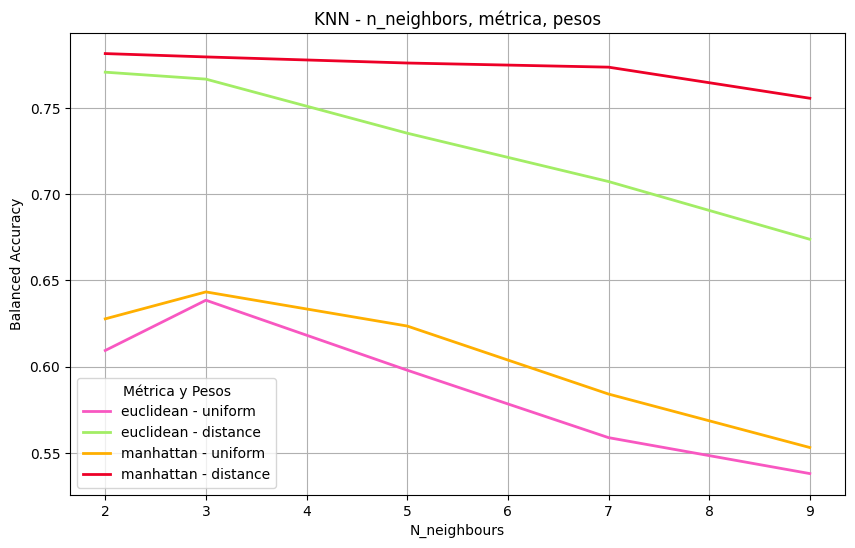

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir los resultados de GridSearchCV en un DataFrame
results_df = pd.DataFrame(grid_search_knn.cv_results_)

# Crear una nueva columna que combine métrica y peso
results_df["metric_weights"] = results_df["param_knn__metric"] + " - " + results_df["param_knn__weights"]

# Definir colores personalizados
custom_palette = {
    "euclidean - uniform": "#F857C1",  # Rosa
    "euclidean - distance": "#a2ed65",  # Verde
    "manhattan - uniform": "#FFAF00",  # Amarillo
    "manhattan - distance": "#ed0027" # Rojo
}

# Crear el gráfico con las combinaciones separadas
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="param_knn__n_neighbors",
    y="mean_test_score",
    hue="metric_weights",  # Diferencia por métrica y pesos
    markers=False,
    dashes=False,
    linewidth=2,
    palette=custom_palette
)

# Personalización del gráfico
plt.xlabel("N_neighbours")
plt.ylabel("Balanced Accuracy")
plt.title("KNN - n_neighbors, métrica, pesos")
plt.legend(title="Métrica y Pesos")
plt.grid(True)
plt.show()


**Árbol de Decisión y max_depth.**

Un árbol de decisión divide recursivamente el conjunto de datos basándose en características (con cada característica -nodo del árbol-, se crean distintas divisiones -ramas del árbol-). Aquí el hiperparámetro max_depth indica la profundidad máxima del árbol (la cantidad máxima de particiones).  

Se observa en el gráfico que la precisión del algoritmo es mayor cuanto mayor es la profundidad máxima. No obstante, la diferencia de resultados a partir de los 15 árboles de profundidad es marginal.

El hiperparámetro min_samples_split, por otro lado, establece el número mínimo de instancias que debe haber para hacer una partición. Cuanto menor es, más particiones puede hacer el algoritmo y por tanto, más precisa es su separación de datos. De forma similar funciona el hiperparámetro min_samples_leaf, solo que este se refiere a instancias para formar un nodo terminal (hoja).

Es por ello que el mejor rendimiento del modelo lo encontramos con min_samples_split=2 y min_samples_leaf=1, en donde la división de datos es lo más precisa. Respecto a la profundidad máxima, como se ha apreciado anteriormente, es igual de válida max_depth=15 que max_depth=20, ya que los resultados son similares (y de hecho max_depth=15 podría reducir el coste computacional).

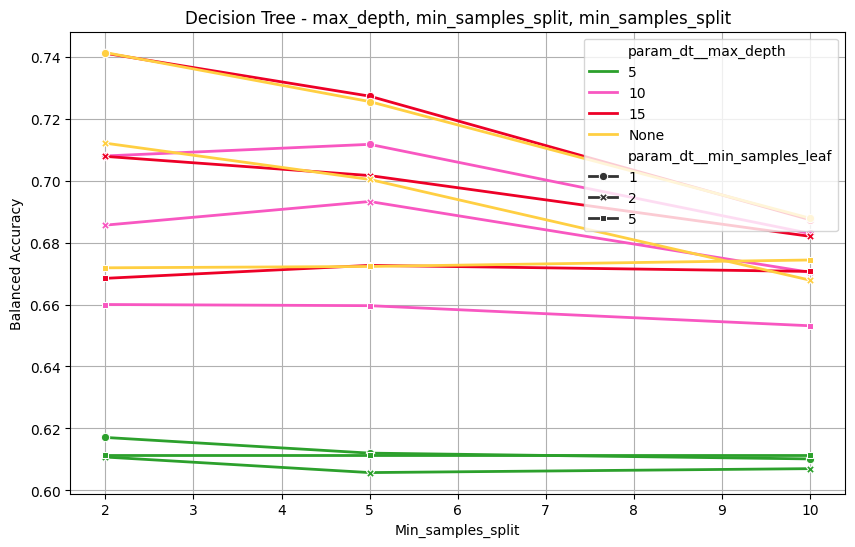

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir los resultados de GridSearchCV en un DataFrame
results_dt_df = pd.DataFrame(grid_search_dt.cv_results_)

# Convertir None a cadena para evitar errores en la gráfica
results_dt_df['param_dt__max_depth'] = results_dt_df['param_dt__max_depth'].astype(str)

# Definir una paleta de colores personalizada
custom_palette_dt = {
    "5": "#2ca02c",   # Verde
    "10":  "#F857C1",   # Rosa
    "15": "#ed0027", # Rojo
    "None": "#ffcf42"  # Amarillo
}

# Crear un gráfico combinado
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_dt_df,
    x="param_dt__min_samples_split",
    y="mean_test_score",
    hue="param_dt__max_depth",  # Diferencia por max_depth
    style="param_dt__min_samples_leaf",  # Diferencia por min_samples_leaf
    markers=True,
    dashes=False,
    linewidth=2,
    palette=custom_palette_dt
)

# Personalización del gráfico
plt.xlabel("Min_samples_split")
plt.ylabel("Balanced Accuracy")
plt.title("Decision Tree - max_depth, min_samples_split, min_samples_split")
plt.grid(True)
plt.show()


**Random Forest y n_estimators**

Random Forest crea un bosque de N árboles de decisión y da como resultado la media o el valor mayoritario de todos los árboles. En este algoritmo, encontramos el hiperparámetro n_estimators, indicando la cantidad de árboles a usar, y los hiperparámetros de cada árbol individual (max_depth, min_samples_leaf, min_samples_split).

Para estudiar el comportamiento del algoritmo frente a los hiperparámetros, hemos querido simplificar ajustando min_samples_leaf=1 y mean_samples_split=2, ya que hemos visto en el apartado anterior (Decision Tree) que son los que mejores resultados dan. Por lo tanto, nos centramos únicamente en la cantidad de árboles y la profundidad de estos.

Como podemos ver en el gráfico, al aumentar la cantidad y profundidad de árboles, mejoran las predicciones del modelo. Por tanto, es coherente que el mejor modelo se haya obtenido con n_estimators=200 y max_depth=None.

(Añadir, no obstante, que los resultados fueron similares para los 3 valores de n_estimators (50, 100, 200). De ello también podemos concluir que podría usarse un valor menor de n_estimators y seguir consiguiendo una accuracy similar, lo cual reduciría el el costo computacional).

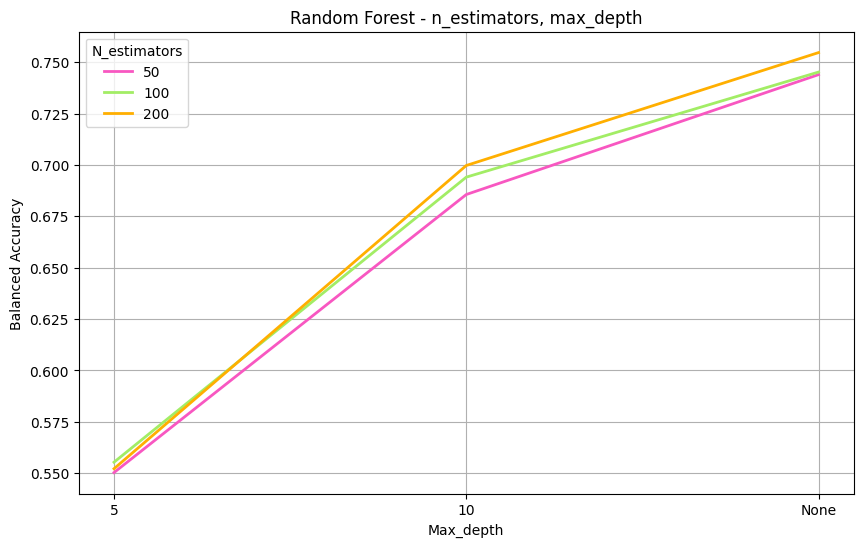

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir los resultados de GridSearchCV en un DataFrame
results_df = pd.DataFrame(grid_search_rf.cv_results_)

# Filtrar solo los valores con min_samples_split=2 y min_samples_leaf=1
filtered_df = results_df[
    (results_df["param_rf__min_samples_split"] == 2) &
    (results_df["param_rf__min_samples_leaf"] == 1)
].copy()

# Convertir None en una cadena para evitar errores en Seaborn
filtered_df["param_rf__max_depth"] = filtered_df["param_rf__max_depth"].astype(str)

# Definir colores personalizados para cada número de árboles (n_estimators)
custom_palette = {
    50: "#F857C1",  # Rosa
    100: "#a2ed65",  # Verde
    200: "#FFAF00"  # Amarillo
}

# Crear el gráfico con las combinaciones separadas
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_df,
    x="param_rf__max_depth",  # Eje X -> Profundidad máxima
    y="mean_test_score",       # Eje Y -> Balanced Accuracy
    hue="param_rf__n_estimators",  # Diferencia por número de árboles
    markers=True,
    dashes=False,
    linewidth=2,
    palette=custom_palette
)

# Personalización del gráfico
plt.xlabel("Max_depth")
plt.ylabel("Balanced Accuracy")
plt.title("Random Forest - n_estimators, max_depth")
plt.legend(title="N_estimators")
plt.grid(True)
plt.show()


**Balanced Random Forest**

Balanced Random Forest es una variante de RF útil para datasets desbalanceados, como es nuestro caso. En vez de entrenar los árboles con subconjuntos aleatorios de datos, lo hace con subconjuntos que mantengan esa misma desproporción (haciendo oversampling de la clase minoritaria o undersampling de la clase mayoritaria).

Decidimos para este modelo usar un boxplot -el cual muestra la dispersión de resultados- en lugar de líneas de regresión, ya que los resultados que devolvía este último gráfico eran muy parecidos por trabajar con las medias.

<ipython-input-49-5fd42f4cf038>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


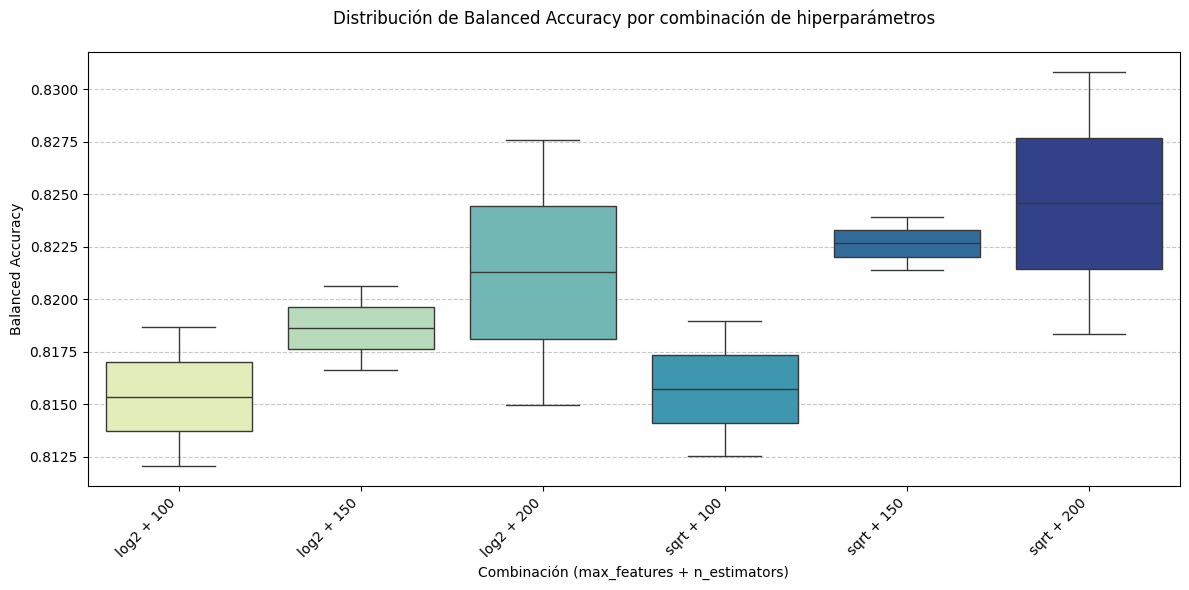

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Extraemos los resultados del GridSearchCV
results = pd.DataFrame(gs_brf.cv_results_)

# Convertimos los hiperparámetros a tipos adecuados
results['param_brf__n_estimators'] = results['param_brf__n_estimators'].astype(int)
results['param_brf__max_features'] = results['param_brf__max_features'].astype(str)

# Creamos una columna combinada para las categorías del boxplot
results['combinacion_hiperparams'] = results['param_brf__max_features'] + " + " + results['param_brf__n_estimators'].astype(str)

# Ordenamos las combinaciones para mejor visualización
results = results.sort_values(by=['param_brf__max_features', 'param_brf__n_estimators'])

# Dibujamos el boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results,
    x='combinacion_hiperparams',
    y='mean_test_score',
    palette="YlGnBu"
)

# Personalizamos el gráfico
plt.title('Distribución de Balanced Accuracy por combinación de hiperparámetros', pad=20)
plt.xlabel('Combinación (max_features + n_estimators)')
plt.ylabel('Balanced Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotamos las etiquetas para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Podemos observar que usar √n_features funciona mejor que log₂(n_features) ya que los valores de la derecha son en general mayores que los de la izquierda. Ello se debe a que sqrt toma más features por división que log2 (√n > log2(n)), por lo que tiene más información en cuenta.

Por otro lado, el número de árboles (n_estimators) parece ser directamente proporcional a la precisión obtenida. Cuantos más árboles, mejores resultados se obtienen de media.

Concluimos entonces que la mejor combinación es max_features = sqrt y n_estimators = 200.

**Redes Neuronales**

Una red neuronal se compone de neuronas artificiales (nodos) las cuales se organizan en capas. Cada neurona en una capa recibe inputs, les aplica una trasformación  lineal *(pesos×inputs + sesgo)* seguida de una función de activación, y propaga el resultado a las neuronas de la siguiente capa.

De nuevo usamos un boxplot para este modelo, en el que analizamos los resultados en función de batch_size (muestras procesadas antes de cada actualización de pesos) y activation (función para activar la neurona), que consideramos que son los hiperparámetros más importantes.

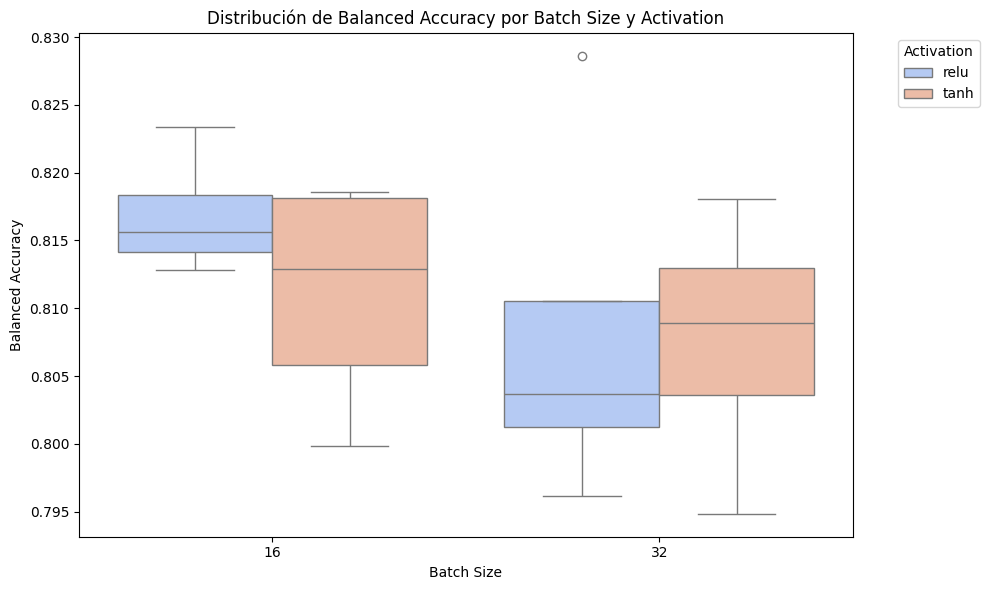

In [ ]:
# Extraemos los resultados del GridSearchCV y los convertimos a DataFrame
import pandas as pd
results_all_folds = pd.DataFrame(grid_search_rn.cv_results_)

# Generamos el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_all_folds,
    x='param_rn__batch_size',
    y='mean_test_score',
    hue='param_rn__activation',
    palette="coolwarm"
)
plt.title('Distribución de Balanced Accuracy por Batch Size y Activation')
plt.xlabel('Batch Size')
plt.ylabel('Balanced Accuracy')
plt.legend(title='Activation', bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera del gráfico
plt.tight_layout()  # Ajusta el layout para evitar cortes
plt.show()

Vemos que batch_size=16 tiene una mayor media y menor dispersión en ambas funciones de activación, lo que sugiere que actualizar los pesos de poco en poco ayuda al modelo a converger mejor.

Curiosamente, la mejor balanced accuracy se obtuvo de batch_size=32 y activation=relu, pero este resulta ser un punto ruidoso. Si aprovechamos la gráfica y observamos las medias y varianzas, vemos que la mejor combinación resulta ser batch_size=16 y función de activación ReLU (Rectified Linear Unit).

**MODELO GANADOR**

Al analizar los resultados finales, al margen de los gráficos, vemos que casi todos los algoritmos obtuvieron resultados similares tanto con la mejor configuración de hiperparámetros como con los hiperparámetros por omisión.

En cambio, para KNN la diferencia entre configurar los hiperparámetros o no sí fue notable (0.7814 frente a 0.5980).

Los resultados de la Balanced Accuracy con la mejor combinación de hiperparámetros para cada modelo fueron:
* KNN: 0.7814224066900163
* DT: 0.7509605098489803
* RF: 0.7565373736780784
* BRF: 0.8308137484540593
* RN: 0.8286204411088841

Vemos entonces que el mejor modelo es BRF, con una Balanced Accuracy superior a todas las demás.

Sin embargo, al analizar el coste computacional, Balanced Random Forest no resultó el mejor algoritmo. Los tiempos de ejecución para cada modelo, con su mejor combinación de hiperparámetros, fueron:
* KNN: 4.293073415756226
* DT: 1.9049146175384521
* RF: 49.34200477600098
* BRF: 11.668444156646729 s
* RN: 49.11739921569824 s

Aquí observamos que el modelo más rápido no es BRF, sino Decision Tree. Debemos entonces evaluar el trade-off entre velocidad y precisión de los algoritmos.

Si bien DT ofrece una velocidad extrema, su rendimiento es de hecho el más bajo. Consideramos que el tiempo no es excesivamente crítico en nuestro problema (11s sigue siendo bajo), por lo que en efecto tomamos BRF como el mejor modelo. Si tuviésemos que priorizar el tiempo, no obstante, podríamos escoger KNN.

---

### **5. AVANZADOS: MODELOS LINEALES y SVMs**



En esta sección evaluaremos modelos lineales (con y sin regularización L1) y SVMs.
Evaluaremos sus rendimientos y tiempos de ejecución usando primero hiperparámetros por omisión y, después, ajustando los hiperparámetros con GridSearch. El objetivo es encontrar los mejores hiperparámetros para cada algoritmo. Además, descubriremos qué variables son las más influyentes en el conjunto de datos.

- Carga de librerías necesarias.

In [ ]:
import time
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

- Modelo lineal con hiperparámetros por omisión.

Los modelos lineales establecen una relación entre una o más variables (variables independientes) y un resultado (variable dependiente). El modelo más básico sería una regresión lineal, pero este es apropiado para problemas de valores continuos.
En nuestro caso, utilizaremos una regresión logística ya que es ideal para problemas de clasificación binaria. Los modelos de regresión logística acotan el resultado entre 0 y 1, siendo 0 Attrition='No' y 1 Attrition='Yes' en nuestro problema.

In [ ]:
# El modelo utilizado ha sido el de regresión logística

pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                                # Rellenamos valores faltantes con la media
    ('scaler', StandardScaler()),                                               # Estandarización de datos
    ('model', LogisticRegression(random_state=NIA))                                             # El modelo a aplicar será: Regresión Logística
])

inicio = time.time()                                                                        # Tomamos una medida del tiempo incial
scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada utilizando balanced_accuracy
tiempo_lr = time.time() - inicio                                                            # Cerramos la medida del tiempo, indicando cuando ha tardado

print("Regresión Logística,", "Score:", np.mean(scores_lr), ", Tiempo:", tiempo_lr, "s")    # Mostramos un mensaje por pantalla con los resultados

- Máquinas de Vectores de Soporte (SVMs) con hipérparametros por omisión.

Las SVMs tratan de encontrar una recta o plano que separe correctamente las instancias del conjunto de datos (representadas como puntos). El objetivo es encontrar aquel plano con mayor distancia entre él y los puntos.

A diferencia de los modelos lineales clásicos, como la regresión logística, las SVM pueden resolver problemas donde los datos no son linealmente separables usando kernels (transformar los datos a un espacio de mayor dimensión donde sí es posible encontrar una separación).


In [ ]:
# La SVM utilizada ha sido la Máquina de Vectores de Soporte (SVM) de Clasificación

pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                                # Rellenamos valores faltantes con la media
    ('scaler', RobustScaler()),                                               # Estandarización de datos
    ('model', SVC(random_state=NIA))                                                            # El modelo a aplicar será: SVM de clasificación
])

inicio = time.time()                                                                          # Tomamos una medida del tiempo incial
scores_svm = cross_val_score(pipeline_svm, X_train, y_train, cv=cv_inner, scoring="balanced_accuracy")    # Validación cruzada utilizando balanced_accuracy
tiempo_svm = time.time() - inicio                                                             # Cerramos la medida del tiempo, indicando cuando ha tardado

print("SVM,", "Score:", np.mean(scores_svm), ", Tiempo:", tiempo_svm, "s")      # Mostramos un mensaje por pantalla con los resultados

- Modelos Lineales con ajuste de hipérparametros (HPO).

In [ ]:
param_grid_lr = [{                                                               # Establecemos los parámetros de la búsqueda HPO con Regresión Logística
    'model__C': [0.01, 0.1, 1, 10, 100],                                        # Valores para el parametro de regularización C
    'model__penalty': ['l1'],                                             # Tipos de penalizacion (con penalización L1)
    'model__solver': ['liblinear']                                              # El solver 'liblinear' soporta las penalizaciones, hace falta para L1
},
{ # Primero todas las combinaciones con regularización y luego las sin regularización, evitando warnings
        'model__penalty': [None],
        'model__solver': ['newton-cholesky'] # Requerido para modelos no penalizados (no funciona liblinear)
    }
]
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv_inner, scoring="balanced_accuracy", n_jobs=-1)   # Iniciamos la busqueda con el Pipeline de Regresión Logística
inicio = time.time()                                                                                             # Tomamos una medida del tiempo incial
grid_search_lr.fit(X_train, y_train)                                                                                         # Validación cruzada utilizando balanced_accuracy
tiempo_gs_lr = time.time() - inicio                                                                              # Cerramos la medida del tiempo, indicando cuando ha tardado

print("\nMejor configuración Regresión Logística,", grid_search_lr.best_params_)                       # Mostramos un mensaje por pantalla con los resultados: best params encontrados
print("Mejor Score Regresión Logística,", grid_search_lr.best_score_, ", Tiempo:", tiempo_gs_lr, "s")  # Mostramos un mensaje por pantalla con los resultados: best score obtenido

Máquinas de Vector de Soporte (SVMs) con ajuste de hipérparametros (HPO).

In [ ]:
param_grid_svm = {                                                              # Establecemos los parámetros de la búsqueda HPO con SVC
    'model__C': [0.01, 0.1, 1, 10, 100],                                                  # Valores para el parametro de regularización C
    'model__kernel': ['poly', 'rbf'],                                         # Queremos probar los tipos de kernel: lineal (Modelos Lineales), y rbf (No Lineal, otro)
    'model__gamma': ['scale', 'auto']
    }

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv_inner, scoring="balanced_accuracy", n_jobs=-1) # Iniciamos la busqueda con el Pipeline de SVC
inicio = time.time()                                                                                              # Tomamos una medida del tiempo incial
grid_search_svm.fit(X_train, y_train)                                                                                         # Validación cruzada utilizando balanced_accuracy
tiempo_gs_svm = time.time() - inicio                                                                              # Cerramos la medida del tiempo, indicando cuando ha tardado

print("\nMejor configuración SVM,", grid_search_svm.best_params_)                           # Mostramos un mensaje por pantalla con los resultados: best params encontrados
print("Mejor Score SVM,", grid_search_svm.best_score_, ", Tiempo:", tiempo_gs_svm, "s")     # Mostramos un mensaje por pantalla con los resultados: best score obtenido

Ahora entrenamos el modelo con los mejores hiperparámetros obtenidos de GridSearch y buscamos los atributos más importantes.

- Atributos relevantes en Modelos Lineales (Regresión Logística) -> mejorar los comentarios

In [ ]:
# Definir el pipeline con imputación, escalado y modelo
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Rellenar valores faltantes con la media
    ('scaler', StandardScaler()),                # Normalizar los datos
    ('model', LogisticRegression(C=100, penalty='l1', solver='liblinear', random_state=NIA))  # Modelo con mejores hiperparámetros
])

# Entrenar el modelo con el pipeline
pipeline_lr.fit(X, y)

# --------------- < continuación > --------------------

# Asegurarse de que los modelos están entrenados con los mejores hiperparámetros encontrados
pipeline_lr.fit(X_train, y_train)

# Importancia de atributos en Regresión Logística
feature_importance_lr = np.abs(pipeline_lr.named_steps['model'].coef_).flatten()
print("Importancia de atributos en Regresión Logística:", feature_importance_lr)

feature_names = X_train.columns  # Asegúrate de que X_train es un DataFrame para obtener nombres de columnas

df_importance_lr = pd.DataFrame({'Atributo': feature_names, 'Importancia': feature_importance_lr})

# Ordenar por importancia
df_importance_lr = df_importance_lr.sort_values(by="Importancia", ascending=False)

print("\nAtributos más relevantes según Regresión Logística:")
print(df_importance_lr.head(10))  # Muestra los 10 atributos más importantes


- Atributos relevantes en SVMs (SVC)

Usamos permutation importance para hallar la importancia de los atributos. Esta técnica consiste en medir cuánto disminuye el rendimiento del modelo al modificar cada atributo (si varía mucho el rendimiento, esa variable es importante).

Es necesario usar este algoritmo ya que estamos trabajando con un kernel RBF y no uno lineal (de haber sido lineal usaríamos el procedimiento de coeficientes anterior).

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Definir el pipeline con imputación, escalado y mejores parámetros para el modelo SVM
pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Rellenar valores faltantes con la media
    ('scaler', RobustScaler()),                # Normalizar los datos
    ('model', SVC(C=20, kernel='rbf', random_state=NIA))           # SVM con los mejores hiperparámetros encontrados
])

# Entrenar el modelo con el pipeline
pipeline_svm.fit(X_train, y_train)

# Calcular permutation importance
result = permutation_importance(
    pipeline_svm,
    X_train,
    y_train,
    n_repeats=10,
    random_state=NIA
)

# Obtener la importancia promedio
feature_importance_svm = result.importances_mean

print("Importancia de atributos en SVM (RBF):", feature_importance_svm)

# Crear DataFrame con los resultados
feature_names = X_train.columns
df_importance_svm = pd.DataFrame({
    'Atributo': feature_names,
    'Importancia': feature_importance_svm
})

# Ordenar por importancia
df_importance_svm = df_importance_svm.sort_values(by="Importancia", ascending=False)

print("\nAtributos más relevantes según SVM (RBF):")
print(df_importance_svm.head(10))  # Muestra los 10 atributos más importantes

Importancia de atributos en SVM (RBF): [0.00121889 0.00426612 0.         0.         0.00010157 0.
 0.         0.         0.         0.         0.         0.00050787
 0.0004063  0.00086338 0.00264093 0.00690706 0.         0.0035551
 0.03382428 0.00010157 0.0083291  0.         0.00726257 0.01051295
 0.00959878 0.00807517 0.00797359 0.00060945 0.00391061 0.00766887
 0.01711529 0.00269172 0.0111224  0.02315896 0.03128492 0.01670899
 0.02001016 0.00909091]

Atributos más relevantes según SVM (RBF):
                              Atributo  Importancia
18                      remainder__hrs     0.033824
34    remainder__TrainingTimesLastYear     0.031285
33        remainder__TotalWorkingYears     0.023159
36  remainder__YearsSinceLastPromotion     0.020010
30       remainder__NumCompaniesWorked     0.017115
35           remainder__YearsAtCompany     0.016709
32         remainder__StockOptionLevel     0.011122
23          remainder__JobSatisfaction     0.010513
24          remainder__WorkLifeBa

Para analizar los resultados de importancia debemos obviar los coeficientes, ya que se han aplicado técnicas diferentes (coeficientes vs permutation importance). Debemos observar qué atributos aparecen en ambos modelos, los cuáles serán por tanto los atributos importantes de nuestro conjunto de datos. Estos son:

*   remainder__TotalWorkingYears (experiencia laboral total)
*   remainder_hrs (horas trabajadas)
* remainder_JobSatisfaction (satisfacción laboral)
* remainder__YearsSinceLastPromotion
* remainder__NumCompaniesWorked
* ord__MaritalStatus
* ord__BusinessTravel



---

### **6. RESULTADOS Y MODELO FINAL**

- Selección de la mejor alternativa de las evaluadas usando cv_inner

In [ ]:
modelo_final = grid_search_rn

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100495893, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', RobustScaler()),
                                       ('rn', MLPClassifier(max_iter=500))]),
             n_jobs=-1,
             param_grid={'rn__activation': ['relu', 'tanh'],
                         'rn__alpha': [0.001, 0.01], 'rn__batch_size': [16, 32],
                         'rn__hidden_layer_sizes': [(150,)],
                         'rn__learning_rate_init': [0.01],
                         'rn__max_iter': [150, 200], 'rn__solver': ['adam']},
             scoring='balanced_accuracy')


- Estimación del rendimiento / desempeño futuro del modelo

In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred = modelo_final.predict(X_test)
print("Precision: ", balanced_accuracy_score(y_test, y_pred))

- Entrenamiento del modelo final «modelo_final.pkl»

In [ ]:
import joblib

modelo_final.fit(X, y)
joblib.dump(modelo_final, "modelo_final.pkl")
print("Modelo final guardado como modelo_final.pkl")